# First Steps with Textual Data

The purpose of this lab is introduce first steps in natural language processing. Much of this content is based on Albrecht, Ramachandran and Winkler (2020) Blueprints for Text Analytics Using Python. O'Reilly


## Load Python Settings

Our first step is always to import the libraries that we will be using and setting defaults for formatting in Matplotlib, Pandas etc. Remember, we must activate the conda environment first before we launch this notebook in the environment. 

In [1]:
# suppress warnings
import warnings;
warnings.filterwarnings('ignore');

# common imports
import pandas as pd
import numpy as np
import math
import re
import glob
import os
import sys
import json
import random
import pprint as pp
import textwrap
import sqlite3
import logging

import spacy
import nltk

from tqdm.auto import tqdm
# register `pandas.progress_apply` and `pandas.Series.map_apply` with `tqdm`
tqdm.pandas()

# pandas display options
# https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html#available-options
pd.options.display.max_columns = 30 # default 20
pd.options.display.max_rows = 60 # default 60
pd.options.display.float_format = '{:.2f}'.format
# pd.options.display.precision = 2
pd.options.display.max_colwidth = 200 # default 50; -1 = all
# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)

# np.set_printoptions(edgeitems=3) # default 3

import matplotlib
from matplotlib import pyplot as plt

plot_params = {'figure.figsize': (8, 4), 
               'axes.labelsize': 'large',
               'axes.titlesize': 'large',
               'xtick.labelsize': 'large',
               'ytick.labelsize':'large',
               'figure.dpi': 100}
# adjust matplotlib defaults
matplotlib.rcParams.update(plot_params)

import seaborn as sns
sns.set_style("darkgrid")

# Introducing the Dataset


In [2]:
pd.options.display.max_colwidth = 150 ###
file = "un-general-debates.csv"
df = pd.read_csv(file)
df.sample(2, random_state=53) #pull two random rows in the dataset to observe, include seed so that we can replicate

#note that we can use df.sample to generate a sample data set when we have something very large in memory. 
#df2=df.sample(frac=0.1)

,session,year,country,country_name,speaker,position,text
3871,51,1996,PER,Peru,Francisco Tudela Van Breughel Douglas,Minister for Foreign Affairs,"﻿At the outset, allow me,\nSir, to convey to you and to this Assembly the greetings\nand congratulations of the Peruvian people, as well as\ntheir..."
4697,56,2001,GBR,United Kingdom,Jack Straw,Minister for Foreign Affairs,"﻿Please allow me\nwarmly to congratulate you, Sir, on your assumption of\nthe presidency of the fifty-sixth session of the General\nAssembly.\nThi..."


# Getting an Overview of the Data with Pandas


## Calculating Summary Statistics for Columns


In [3]:
#We want to get more information about the length of each speech
df['length'] = df['text'].str.len()

#Here we will create summary statistics, but transpose the presentation
df.describe().T

,count,mean,std,min,25%,50%,75%,max
session,7507.00,49.61,12.89,25.00,39.00,51.00,61.00,70.00
year,7507.00,1994.61,12.89,1970.00,1984.00,1996.00,2006.00,2015.00
length,7507.00,17967.28,7860.04,2362.00,12077.00,16424.00,22479.50,72041.00


In [4]:
# We would like to identify the number of countries and speakers. Data from 1970-2015 UN General Debates
df[['country', 'speaker']].describe(include='O').T

,count,unique,top,freq
country,7507,199,ALB,46
speaker,7480,5428,Seyoum Mesfin,12


## Checking for Missing Data


In [5]:
#We have missings on position and some under speaker
df.isna().sum()

session            0
year               0
country            0
country_name       0
speaker           27
position        3005
text               0
length             0
dtype: int64

In [6]:
#We can replace missings with "unknown" this will keep the record in the analysis
df['speaker'].fillna('unkown', inplace=True)

In [7]:
df[df['speaker'].str.contains('Bush')]['speaker'].value_counts()

George W. Bush        4
Mr. George W. Bush    2
Bush                  1
George Bush           1
Mr. George W Bush     1
Name: speaker, dtype: int64

## Plotting Value Distributions


<AxesSubplot:>

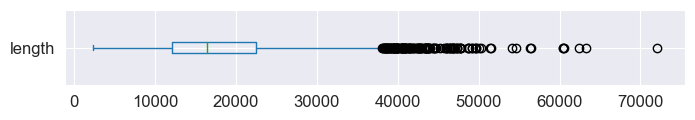

In [8]:
#Produce a box plot with speech length
df['length'].plot(kind='box', vert=False, figsize=(8, 1))

<AxesSubplot:ylabel='Frequency'>

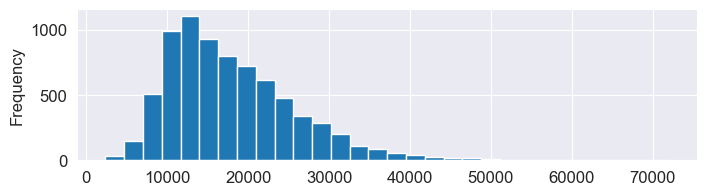

In [9]:
#Could also create a histogram with 30 intervals, or bins.
df['length'].plot(kind='hist', bins=30, figsize=(8,2))

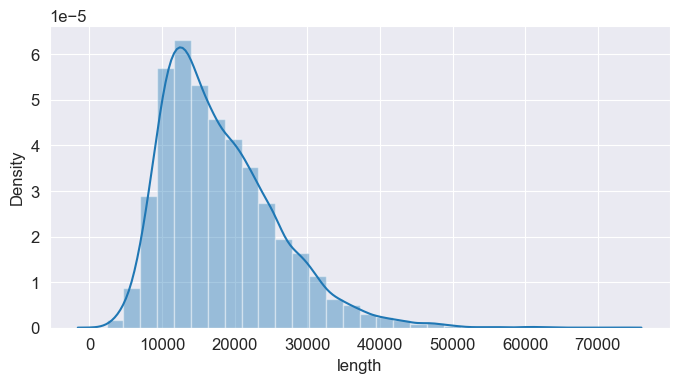

In [10]:
#Seaborn plot with gaussian kernel density estimate
import seaborn as sns

sns.distplot(df['length'], bins=30, kde=True);

## Comparing Value Distributions across Categories


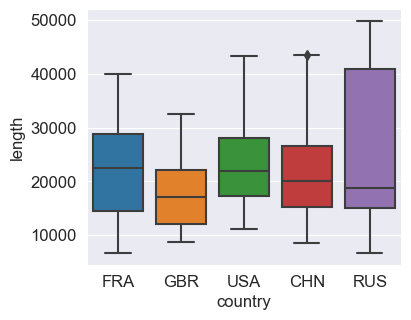

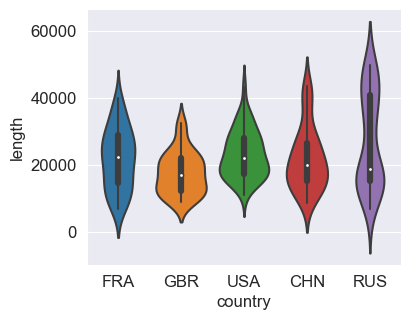

In [11]:
#catplot in seaborn makes nice visualizations to compare distributions of speech length by country
where = df['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS'])
g = sns.catplot(data=df[where], x="country", y="length", kind='box')
g.fig.set_size_inches(4, 3) ###
g.fig.set_dpi(100) ###
g = sns.catplot(data=df[where], x="country", y="length", kind='violin')
g.fig.set_size_inches(4, 3) ###
g.fig.set_dpi(100) ###

## Visualizing Developments over Time


<AxesSubplot:title={'center':'Number of Countries'}, xlabel='year'>

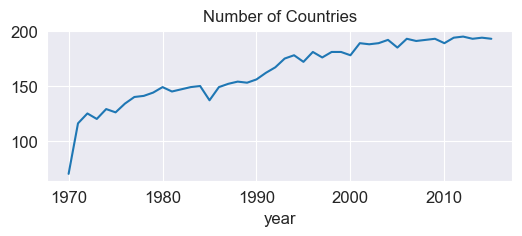

In [12]:
#We can look at the development of number of UN members and the average speech length. 
df.groupby('year').size().plot(title="Number of Countries", figsize=(6,2))

<AxesSubplot:title={'center':'Avg. Speech Length'}, xlabel='year'>

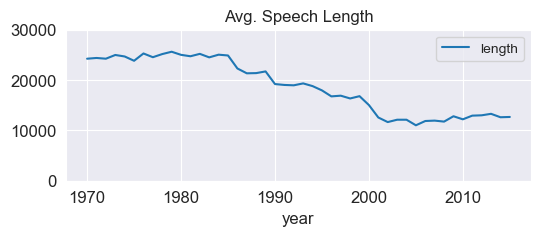

In [13]:
df.groupby('year').agg({'length': 'mean'}) \
  .plot(title="Avg. Speech Length", ylim=(0,30000), figsize=(6,2))

# Building a Simple Text Preprocessing Pipeline


## Tokenization with Regular Expressions
Our goal is to go from source text to prepared tokens. Tokens are the unit of analysis we are interested in. Our steps will follow accordingly 1) Case folding, 2) Tokenization, 3) Stop word remvoval

Tokenization is the process of extracting words from a sequence of characters. We will use white space and punctuation to split into tokens. This can be achieved using regular expressions. We will use POSIX \p{L} which selects all Unicode letters rather than re. We include digits, letters and underscores as well as hyphens.


In [14]:
import regex as re

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [15]:
text = "Let's defeat SARS-CoV-2 together in 2020!"
tokens = tokenize(text)
print("|".join(tokens))

Let|s|defeat|SARS-CoV-2|together|in


## Treating Stop Words
Stop words are determiners, auxiliaary verbs, pronouns, adverbs and so on. They often don't carry much meaning but can hide interesting content because of high frequency use. We must be sure to look up stop words included in standard methods. Libraries such as NLTK have a base list, but if you are doing content analysis, this needs to be monitored. May contain negation or may need to include added words specific to your context (here: dear, regards, must, would...) NLTK only contains 179 stop words BUT it includes wouldn't but not would!

In [16]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arjung/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
import nltk

stopwords = set(nltk.corpus.stopwords.words('english'))

In [18]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

We are adding custom stop words to the list provided by NLTK. Stop words have to be adjusted for the data source (Twitter: Lol, etc.) and this becomes powerful in adapting NLTK to your data application.

In [19]:
#Again, we need to be specific because inclusion or exclusion of terms can severally affect our word counts.
include_stopwords = {'dear', 'regards', 'must', 'would', 'also'}
exclude_stopwords = {'against'}

#use union for inclusion and difference for exclusion
stopwords |= include_stopwords
stopwords -= exclude_stopwords

## Processing a Pipeline with one Line of Code


We create the function prepare to tokenize the words, convert the words to lowercase and remove the stop words. `progress_apply()` is a widget from `tqdm` that shows a display bar while applying a function to a vector or dataframe.

In [20]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [21]:
df['tokens'] = df['text'].progress_apply(prepare, pipeline=pipeline)

100%|██████████| 7507/7507 [00:09<00:00, 781.78it/s] 


In [22]:
df['num_tokens'] = df['tokens'].progress_map(len)

100%|██████████| 7507/7507 [00:00<00:00, 214100.16it/s]


In [25]:
df.head()

,session,year,country,country_name,speaker,position,text,length,tokens,num_tokens
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the congratulations of the Albanian delegation on his election to the Presidency of the twenty-fifth sessi...,51419,"[may, first, convey, president, congratulations, albanian, delegation, election, presidency, twenty-fifth, session, general, assembly, taking, wor...",4125
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,"177.\t : It is a fortunate coincidence that precisely at a time when the United Nations is celebrating its first twenty-five years of existence, a...",29286,"[fortunate, coincidence, precisely, time, united, nations, celebrating, first, twenty-five, years, existence, eminent, jurist, closely, linked, or...",2327
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,"100.\t It is a pleasure for me to extend to you, Mr. President, the warmest congratulations of the Australia Government and its delegation to thi...",31839,"[pleasure, extend, mr, president, warmest, congratulations, australia, government, delegation, general, assembly, election, presidency, distinguis...",2545
3,25,1970,AUT,Austria,Mr. KIRCHSCHLAEGER,NaN,"155.\t May I begin by expressing to Ambassador Hambro, on behalf of the delegation of Austria, our best wishes on his election as President of th...",26616,"[may, begin, expressing, ambassador, hambro, behalf, delegation, austria, best, wishes, election, president, general, assembly, derive, great, sat...",2135
4,25,1970,BEL,Belgium,Mr. HARMEL,NaN,"176. No doubt each of us, before coming up to this rostrum, wonders about the usefulness or futility of the speech. Must we still speak when our v...",25911,"[doubt, us, coming, rostrum, wonders, usefulness, futility, speech, still, speak, voices, drowned, mournful, cries, many, victims, world, disorder...",2025


# Word Frequency Analysis


## Counting Words with a Counter
The counter requires tokens in order to measure frequency. In other words, we must tokenize before we can count the frequency.

In [23]:
from collections import Counter

tokens = tokenize("She likes my cats and my cats like my sofa.")

counter = Counter(tokens)
print(counter)

Counter({'my': 3, 'cats': 2, 'She': 1, 'likes': 1, 'and': 1, 'like': 1, 'sofa': 1})


In [26]:
more_tokens = tokenize("she likes dogs and cats.")
counter.update(more_tokens)
print(counter)

Counter({'cats': 4, 'likes': 3, 'my': 3, 'and': 3, 'She': 2, 'dogs': 2, 'like': 1, 'sofa': 1, 'she': 1})


In [27]:
#create ounter and run through all data
counter = Counter()

#transform into a dataframe
_ = df['tokens'].map(counter.update)

In [28]:
pp.pprint(counter.most_common(5))

[('nations', 124508),
 ('united', 120763),
 ('international', 117223),
 ('world', 89421),
 ('countries', 85734)]


In [29]:
from collections import Counter ###
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].progress_map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [30]:
#alternative means of display
freq_df = count_words(df)
freq_df.head(5)

100%|██████████| 7507/7507 [00:01<00:00, 4540.82it/s]


,freq
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734


In [31]:
# top words with 10+ characters
count_words(df, column='text', 
            preprocess=lambda text: re.findall(r"\w{10,}", text)).head(5)

100%|██████████| 7507/7507 [00:07<00:00, 1024.67it/s]


,freq
token,
international,106974
development,51334
Government,35528
Organization,33763
developing,25177


## Creating a Frequency Diagram


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

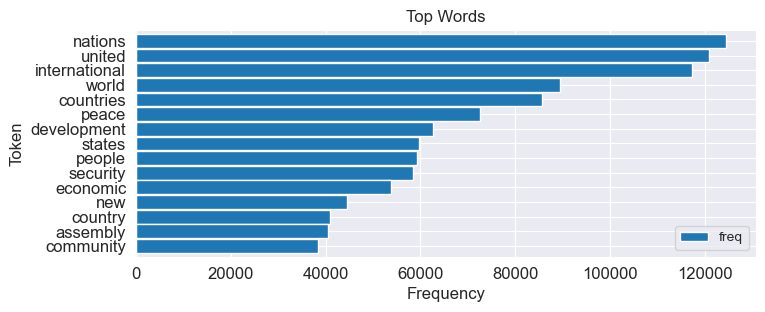

In [32]:
ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

## Creating Word Clouds
Remember that word clouds visualize frequency with different fot size, but they are not perfect. Long words and words with capital letters will catch our attention

(-0.5, 399.5, 199.5, -0.5)

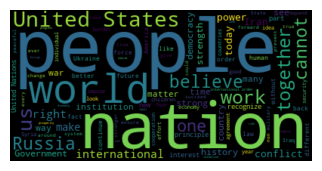

In [33]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

text = df.query("year==2015 and country=='USA'")['text'].values[0]

plt.figure(figsize=(4, 2)) ###
wc = WordCloud(max_words=100, stopwords=stopwords)
wc.generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

In [34]:
from wordcloud import WordCloud ###
from collections import Counter ###

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

100%|██████████| 193/193 [00:00<00:00, 11430.88it/s]


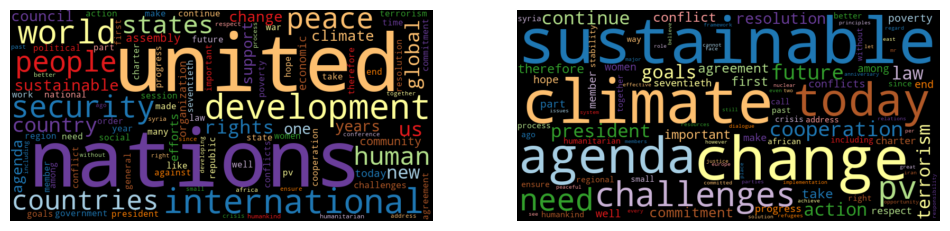

In [43]:
#note that here will will display the results of a word cloud with and without filtering the stop words
freq_2015_df = count_words(df[df['year']==2015])
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)###
wordcloud(freq_2015_df['freq'], max_words=100)
plt.subplot(1,2,2)###
wordcloud(freq_2015_df['freq'], max_words=100, stopwords=freq_df.head(50).index)
#plt.tight_layout()###

## Ranking with TF-IDF
When we want to look at slices of the data, rather than the entire body. This could allow us to look at relative frequency of words in given periods. TF-IDF will highlight words whose actual word frequency in a slice is higher than the total probability would suggest. This stands for term frequency with the inverse document frequency. We are measuring what stands out!

In [36]:
def compute_idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # count tokens
    counter = Counter()
    df[column].progress_map(update)

    # create data frame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

In [37]:
idf_df = compute_idf(df)

100%|██████████| 7507/7507 [00:01<00:00, 3863.85it/s]


In [47]:
# high IDF means rare (interesting) term
idf_df.sample(25).T

token,dot,peculiar,twofold,surinam,re-establishment,fillip,spotlights,guarani,premiums,one-fifth,emirati,poseidon,differed,governs,oilfields,accountabilities,softened,conspicuous,overstrained,creatively,fastest-,signatures,hitlerite,deluge,heroism
df,11.00,146.00,75.00,7.00,151.00,7.00,2.00,3.00,2.00,12.00,6.00,2.00,8.00,92.00,10.00,2.00,6.00,65.00,3.00,48.00,2.00,41.00,24.00,11.00,84.00
idf,6.63,4.04,4.71,7.08,4.01,7.08,8.33,7.92,8.33,6.54,7.23,8.33,6.94,4.50,6.72,8.33,7.23,4.85,7.92,5.15,8.33,5.31,5.85,6.63,4.59


In [39]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

In [40]:
# for more data: joining is faster
freq_df = freq_df.join(idf_df)
freq_df['tfidf'] = freq_df['freq'] * freq_df['idf']

100%|██████████| 193/193 [00:00<00:00, 7327.52it/s]


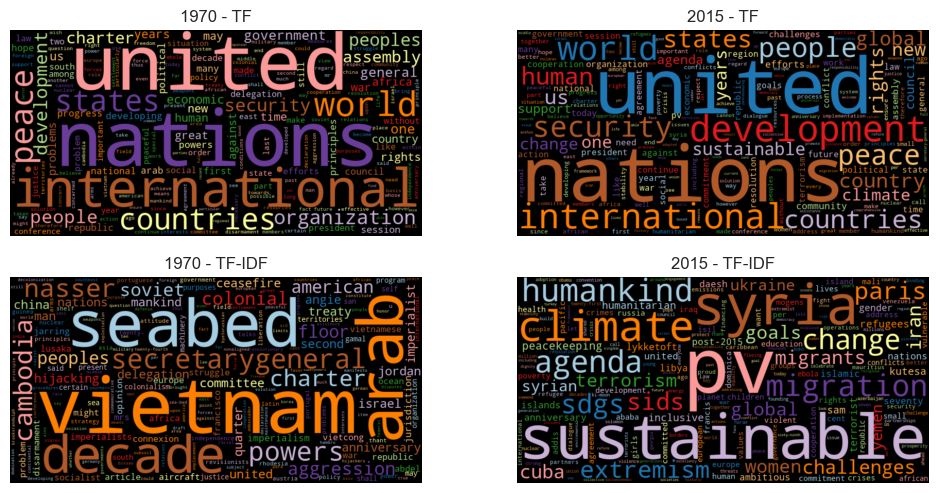

In [41]:
#Here we will look at plain counts vs TF-IDF for various data slices
freq_1970 = count_words(df[df['year'] == 1970])
freq_2015 = count_words(df[df['year'] == 2015])

freq_1970['tfidf'] = freq_1970['freq'] * idf_df['idf']
freq_2015['tfidf'] = freq_2015['freq'] * idf_df['idf']

plt.figure(figsize=(12,6)) ###
#wordcloud(freq_df['freq'], title='All years', subplot=(1,3,1))
plt.subplot(2,2,1)###
wordcloud(freq_1970['freq'], title='1970 - TF', 
          stopwords=['twenty-fifth', 'twenty-five'])
plt.subplot(2,2,2)###
wordcloud(freq_2015['freq'], title='2015 - TF', 
          stopwords=['seventieth'])
plt.subplot(2,2,3)###
wordcloud(freq_1970['tfidf'], title='1970 - TF-IDF', 
          stopwords=['twenty-fifth', 'twenty-five', 'twenty', 'fifth'])
plt.subplot(2,2,4)###
wordcloud(freq_2015['tfidf'], title='2015 - TF-IDF', 
          stopwords=['seventieth'])

# Finding a Keyword in Context (KWIC)


**Note:** textacy's API had major changes from version 0.10.1 to 0.11.  
Here, `textacy.text_utils.KWIC` became `textacy.extract.kwic.keyword_in_context` (see [textacy documentation](https://textacy.readthedocs.io/en/latest/api_reference/extract.html#module-textacy.extract.kwic)).




In [48]:
import textacy

if textacy.__version__ < '0.11': # as in printed book
    from textacy.text_utils import KWIC
    
else: # for textacy 0.11.x
    from textacy.extract.kwic import keyword_in_context

    def KWIC(*args, **kwargs):
        # call keyword_in_context with all params except 'print_only'
        return keyword_in_context(*args, 
                           **{kw: arg for kw, arg in kwargs.items() 
                            if kw != 'print_only'})

In [49]:
def kwic(doc_series, keyword, window=35, print_samples=5):

    def add_kwic(text):
        kwic_list.extend(KWIC(text, keyword, ignore_case=True, 
                              window_width=window, print_only=False))

    kwic_list = []
    doc_series.progress_map(add_kwic)

    if print_samples is None or print_samples==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)} " + \
              f"contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0])+'  '+ \
                  sample[1]+'  '+\
                  re.sub(r'[\n\t]', ' ', sample[2]))

In [50]:
random.seed(22) ###
kwic(df[df['year'] == 2015]['text'], 'sdgs', print_samples=5)

100%|██████████| 193/193 [00:00<00:00, 5819.22it/s]

5 random samples out of 73 contexts for 'sdgs':
 of our planet and its people. The   SDGs   are a tangible manifestation of th
nd, we are expected to achieve the   SDGs   and to demonstrate dramatic develo
ead by example in implementing the   SDGs   in Bangladesh. Attaching due impor
the Sustainable Development Goals (  SDGs  ). We applaud all the Chairs of the
new Sustainable Development Goals (  SDGs  ) aspire to that same vision. The A


# Analyzing N-Grams


In [ ]:
def ngrams(tokens, n=2, sep=' '):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

text = "the visible manifestation of the global climate change"
tokens = tokenize(text)
print("|".join(ngrams(tokens, 2)))

In [ ]:
def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
            if len([t for t in ngram if t in stopwords])==0]

print("Bigrams:", "|".join(ngrams(tokens, 2, stopwords=stopwords)))
print("Trigrams:", "|".join(ngrams(tokens, 3, stopwords=stopwords)))

In [ ]:
df['bigrams'] = df['text'].progress_apply(prepare, pipeline=[str.lower, tokenize]) \
                          .progress_apply(ngrams, n=2, stopwords=stopwords)

count_words(df, 'bigrams').head(5)

In [ ]:
idf_df = compute_idf(df) ### re-initialize to be safe
# concatenate existing IDF data frame with bigram IDFs
idf_df = pd.concat([idf_df, compute_idf(df, 'bigrams', min_df=10)])

freq_df = count_words(df[df['year'] == 2015], 'bigrams')
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

In [ ]:
plt.figure(figsize=(12,6)) ###
plt.subplot(1,2,1) ###
wordcloud(freq_df['tfidf'], title='all bigrams', max_words=50)

plt.subplot(1,2,2) ###
# plt.tight_layout() ###
where = freq_df.index.str.contains('climate')
wordcloud(freq_df[where]['freq'], title='"climate" bigrams', max_words=50)

# Comparing Frequencies across Time-Intervals and Categories


## Creating Frequency Timelines


In [ ]:
def count_keywords(tokens, keywords): 
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

In [ ]:
keywords = ['nuclear', 'terrorism', 'climate', 'freedom']
tokens = ['nuclear', 'climate', 'climate', 'freedom', 'climate', 'freedom']

print(count_keywords(tokens, keywords))

In [ ]:
def count_keywords_by(df, by, keywords, column='tokens'):
    
    df = df.reset_index(drop=True) # if the supplied dataframe has gaps in the index
    freq_matrix = df[column].progress_apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by] # copy the grouping column(s)
    
    return freq_df.groupby(by=by).sum().sort_values(by)

In [ ]:
freq_df = count_keywords_by(df, by='year', keywords=keywords)

In [ ]:
pd.options.display.max_rows = 4

In [ ]:
pd.options.display.max_rows = 60

In [ ]:
freq_df.plot(kind='line', figsize=(8, 3))

In [ ]:
random.seed(23) ###
# analyzing mentions of 'climate' before 1980
kwic(df.query('year < 1980')['text'], 'climate', window=35, print_samples=5)

## Creating Frequency Heat Maps


In [ ]:
keywords = ['terrorism', 'terrorist', 'nuclear', 'war', 'oil',
            'syria', 'syrian', 'refugees', 'migration', 'peacekeeping', 
            'humanitarian', 'climate', 'change', 'sustainable', 'sdgs']  

freq_df = count_keywords_by(df, by='year', keywords=keywords)

# compute relative frequencies based on total number of tokens per year
freq_df = freq_df.div(df.groupby('year')['num_tokens'].sum(), axis=0)
# apply square root as sublinear filter for better contrast
freq_df = freq_df.apply(np.sqrt)

plt.figure(figsize=(10, 3)) ###
sns.set(font_scale=1) ###
sns.heatmap(data=freq_df.T, 
            xticklabels=True, yticklabels=True, cbar=False, cmap="Reds")
sns.set(font_scale=1) ###

# Closing Remarks

In the spirit of good housekeeping- we must remember to carefully save and close out of our Jupyter notebook. You will want to select "close and halt" under File. After closing the browser window, return to your open terminal session. Enter ctrl+c and confirm that you want to end the Jupyter Notebook session. Finally, please remember to type "conda deactivate" at the prompt to close out of the activated conda environment and return to the base environment. 

Next time, when you wish to use this environment, remember that you will open the terminal and type "conda activate pathTofile" at the resulting environment prompt, you will type "jupyter notebook pathTofile" to reopen this notebook. Drag and drop to indicate pathTofile works well on mac computers.